In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = [ 
    dict(name="1e19", id="d45a-d42acb_1e19", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="2e19", id="d42acb-with_guards", unnormalise_geom = True, use_xhermes = True, squash = True), 
    dict(name="3e19", id="d44a-d42acb_3e19", unnormalise_geom = True, use_xhermes = True, squash = True), 

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case d45a-d42acb_1e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:25:51, dmp file date 09/10/2024, 12:44:06


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1140: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d42acb-with_guards
-----------------------
- Looking for squash file
- Squash file found. squash date 09/03/2024, 10:49:23, dmp file date 09/03/2024, 10:28:10


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1140: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case d44a-d42acb_3e19
-----------------------
- Looking for squash file
- Squash file found. squash date 09/10/2024, 15:27:45, dmp file date 09/10/2024, 12:48:53


C:\Users\mikek\OneDrive\Project\python-packages\xBOUT\xbout\load.py:1140: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


In [3]:
cs["1e19"].ds.coords

Coordinates:
    dx                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    dy                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    dz                       (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
    zShift                   (x, theta) float64 dask.array<chunksize=(40, 108), meta=np.ndarray>
  * t                        (t) float64 0.06885 0.0689 ... 0.07746 0.07751
    R                        (x, theta) float64 0.2622 0.2659 ... 0.6401 0.6411
    Z                        (x, theta) float64 -0.7479 -0.7491 ... -0.8113
    poloidal_distance        (x, theta) float64 -0.005844 -0.001948 ... 1.681
    poloidal_distance_ylow   (x, theta) float64 -0.007792 -0.003896 ... 1.679
    total_poloidal_distance  (x) float64 1.542 1.696 1.841 1.962 ... nan nan nan
    zShift_CELL_YLOW         (x, theta) float64 0.2264 0.1157 ... -6.028 -6.048
    Rxy_lower_left_corners   (x, theta) float64 0.

# Read SOLEDGE

In [10]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    # "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    # "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    # "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    # "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    # "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    print(name)
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



tightwall_1e19
tightwall_3e19


# Read SOLPS

In [8]:
solpscases = {

    # "tightwall_noD2_1e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_spectra\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_novisc_spectra" : r"C:\Users\mikek\OneDrive\Project\collab\From\Matteo\2024-11-01 - 1e19 2e19 3e19 no viscosity, spectra\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_spectra_20241106\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_1e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_2e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    # "tightwall_noD2_3e19_fixpuff" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playArounD_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_novisc_fixpuff\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0",
    "tightwall_noD2_1e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_2e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    "tightwall_noD2_3e19_zerophi" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_zero_phi\xxxxOK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2.eirene_ionz=0.b2tqca_phm0=0.b2news_poteq=0",
    
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    # "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    
    # "core_extent_16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    # "widewall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19",
    # "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    # "tightwall_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19",
    # "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    # "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    # "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # _ = read_last10s(solpscases[name], save = True)
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [5]:
cs.keys()

dict_keys(['1e19', '2e19', '3e19'])

In [6]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    ds = cs[name].ds
    if "t" in ds.dims: ds = ds.isel(t=-1)
    hr[name].read_case(ds)

    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

1e19
None 0.001
None 0.001
None 0.003
None 0.015
None 0.03
2e19
None 0.001
None 0.001
None 0.003
None 0.015
None 0.03
3e19
None 0.001
None 0.001
None 0.003
None 0.015
None 0.03


# Convergence

In [ ]:
case = "no_fastrec_tune"
lineplot(
    {
        # "start":cs[case].ds.isel(t=0, x = slice(2,-2)),
        # "-5":cs[case].ds.isel(t=-3, x = slice(2,-2)),
        "last":cs[case].ds.isel(t=-1, x = slice(2,-2)),
        # "base":cs["base"].ds.isel(t=-1, x = slice(2,-2)),

    },
    clean_guards = False,
    params = ["Te", "Td+", "Td", "Ne", "Nd"],
    regions = ["omp", "outer_lower", "field_line"],
)

In [ ]:
cases = { 

    "SOLPS, no D2, no viscosity" : dict(data=sp["tightwall_noD2_1e19_novisc_spectra"], color="deeppink"),
    "SOLEDGE2D" : dict(data=sl["tightwall_1e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['1e19'], color = "teal"),


    },

# New rebaseline - no viscosity

## 1e19

In [10]:
for s in [cs, sp, sl]:
    print(s.keys())

dict_keys(['1e19', '2e19', '3e19'])
dict_keys(['tightwall_noD2_1e19_novisc', 'tightwall_noD2_2e19_novisc', 'tightwall_noD2_3e19_novisc', 'tightwall_noD2_1e19_novisc_spectra', 'tightwall_noD2_2e19_novisc_spectra', 'tightwall_noD2_3e19_novisc_spectra', 'tightwall_noD2_1e19_fixpuff', 'tightwall_noD2_2e19_fixpuff', 'tightwall_noD2_3e19_fixpuff', 'tightwall_noD2_1e19_zerophi', 'tightwall_2e19', 'tightwall_3e19', 'tightwall_noD2_1e19', 'tightwall_noD2_2e19', 'tightwall_noD2_3e19'])
dict_keys(['tightwall_1e19', 'tightwall_2e19', 'widewall_2e19_5m', 'tightwall_3e19', 'widewall_1e19', 'widewall_2e19', 'widewall_3e19'])


In [53]:
sl["tightwall_1e19"].regions["outer_lower"].columns

Index(['Ne', 'Te', 'Jsat_e', 'Me', 'Nd+', 'Td+', 'Jsat_d+', 'Md+,', ' Ioniz_D',
       'Na', 'Nm', 'Ta', 'Tm', 'Sn', 'M', 'Ti', 'walldL', 'L', 'R', 'Z',
       'iWallKnots', 'dist', 'Pe', 'Pd+', 'Pa', 'Pm'],
      dtype='object')

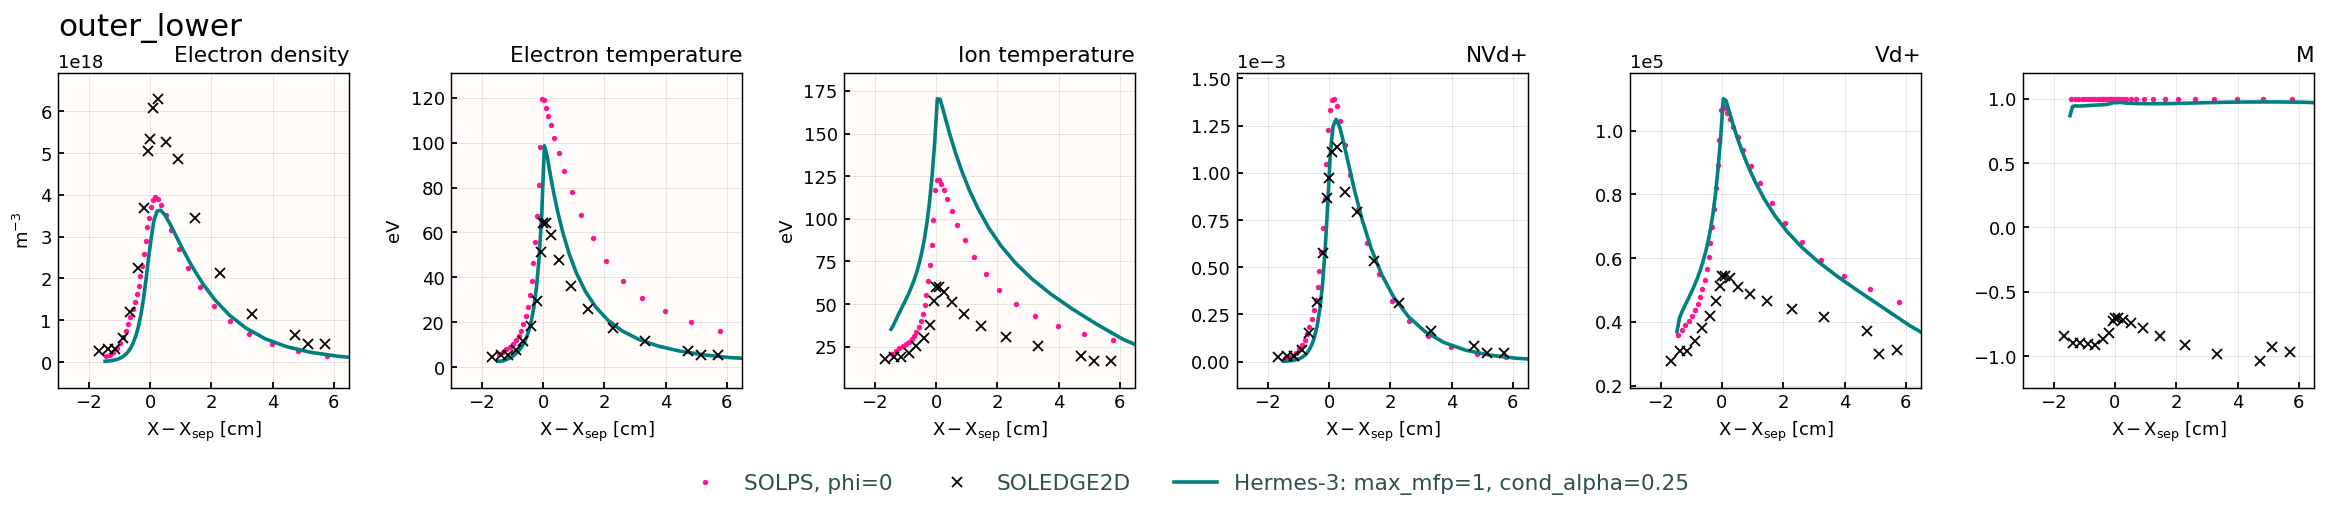

In [7]:
lineplot_compare(
    cases = { 

    "SOLPS, phi=0" : dict(data=sp["tightwall_noD2_1e19_zerophi"], color="deeppink"),
    "SOLEDGE2D" : dict(data=sl["tightwall_1e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['1e19'], color = "teal"),

    },
    regions = [
        "outer_lower"],  
    
    params = ["Ne", "Te", "Td+", "NVd+", "Vd+", "M"],
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)

## 2e19

In [7]:
for s in [cs, sp, sl]:
    print(s.keys())

dict_keys(['1e19', '2e19', '3e19'])
dict_keys(['tightwall_1e19_spectrum', 'tightwall_2e19_spectrum', 'tightwall_3e19_spectrum', 'tightwall_noD2_1e19_spectrum', 'tightwall_noD2_2e19_spectrum', 'tightwall_noD2_3e19_spectrum', 'tightwall_noD2_2e19_novisc'])
dict_keys(['tightwall_1e19', 'tightwall_2e19', 'widewall_2e19_5m', 'tightwall_3e19', 'widewall_1e19', 'widewall_2e19', 'widewall_3e19'])


None not available in SOLEDGE2D, omp
None not available in SOLEDGE2D, imp
None not available in SOLEDGE2D, outer_lower
None not available in SOLEDGE2D, inner_lower


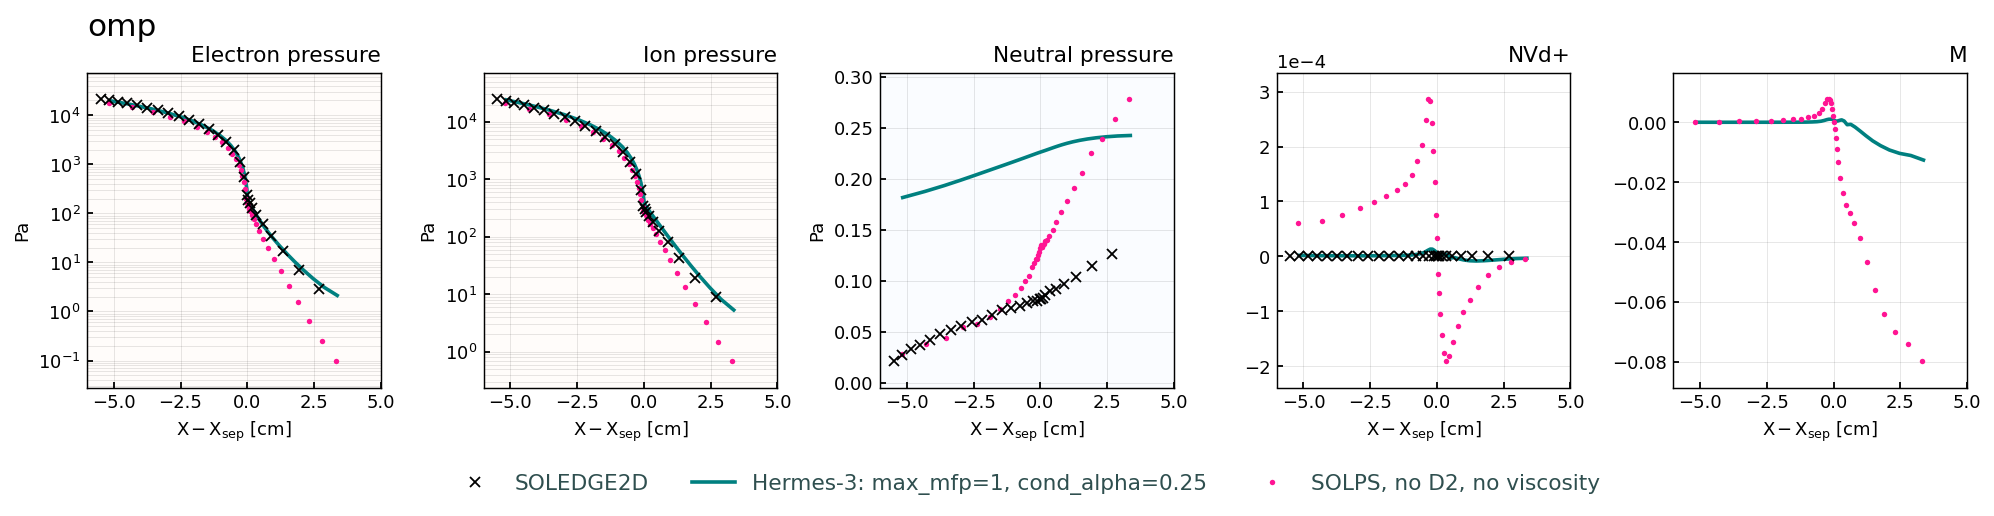

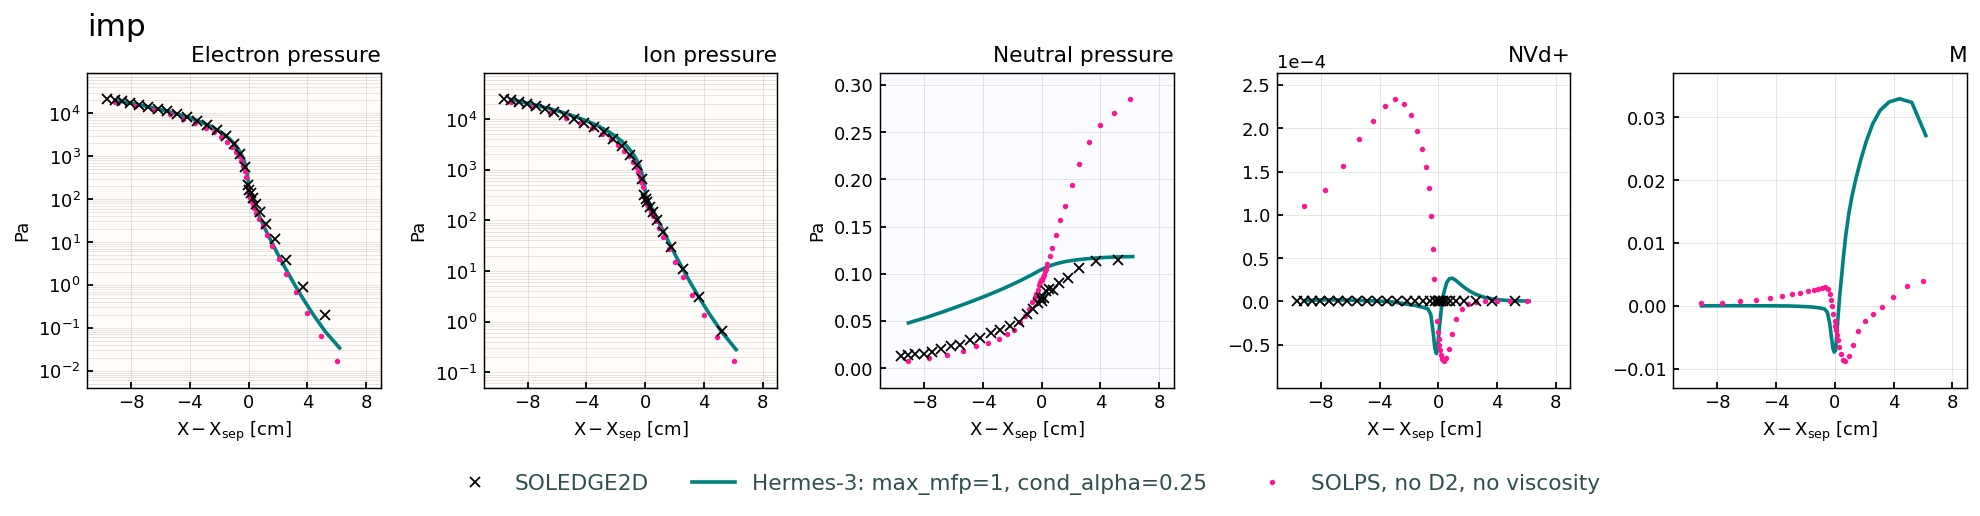

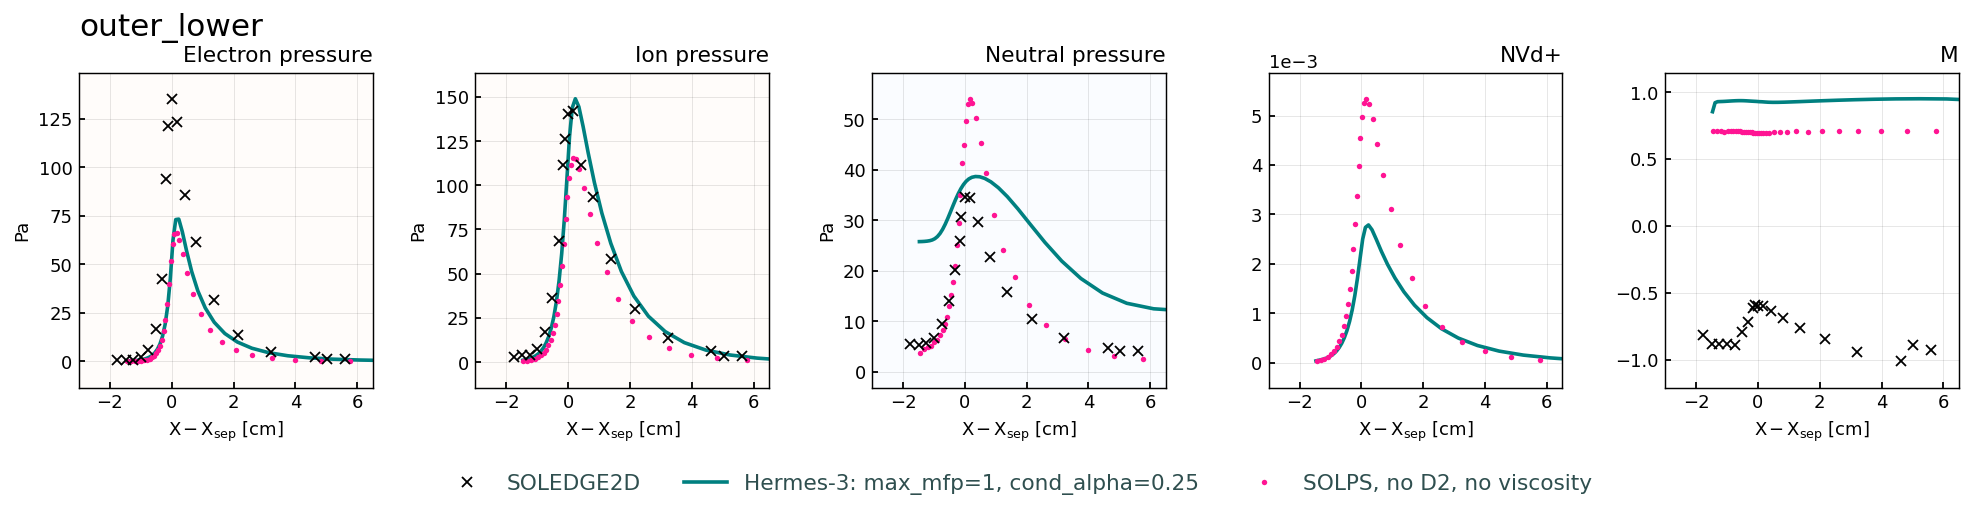

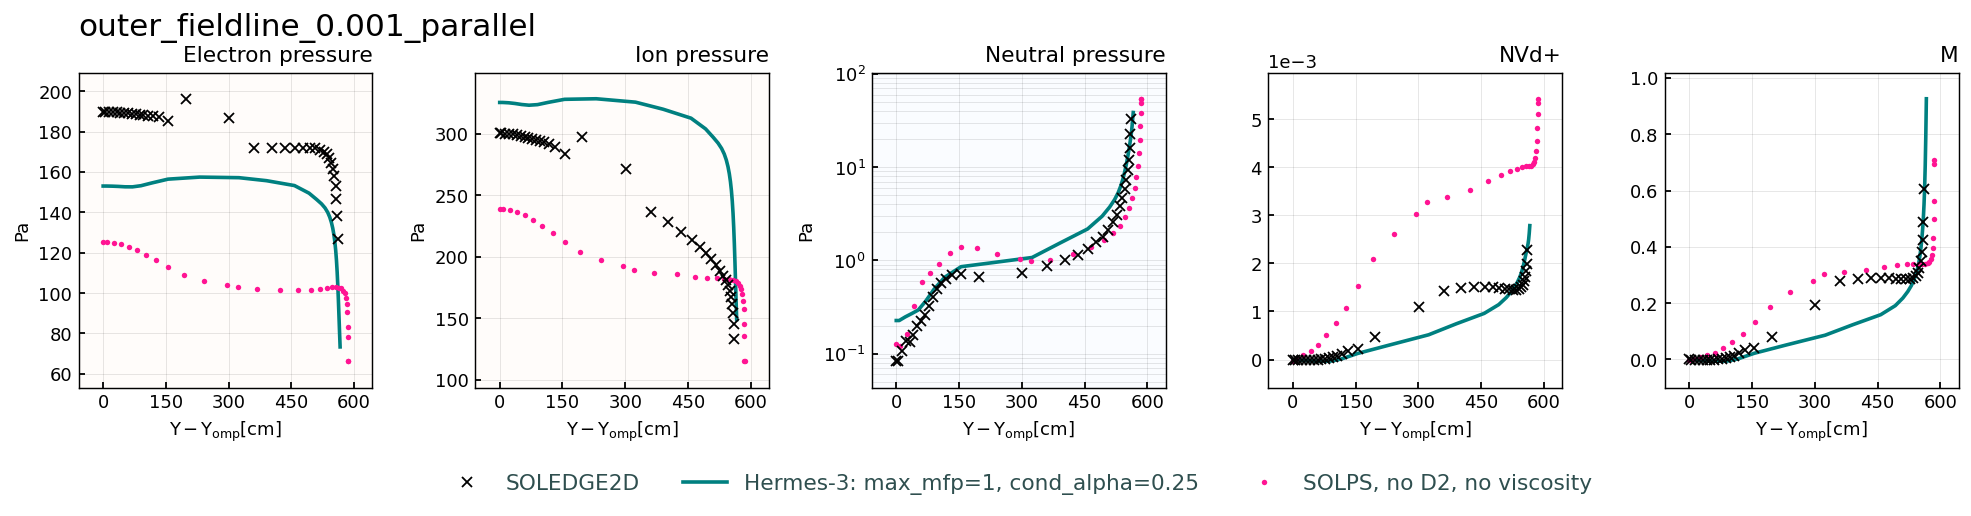

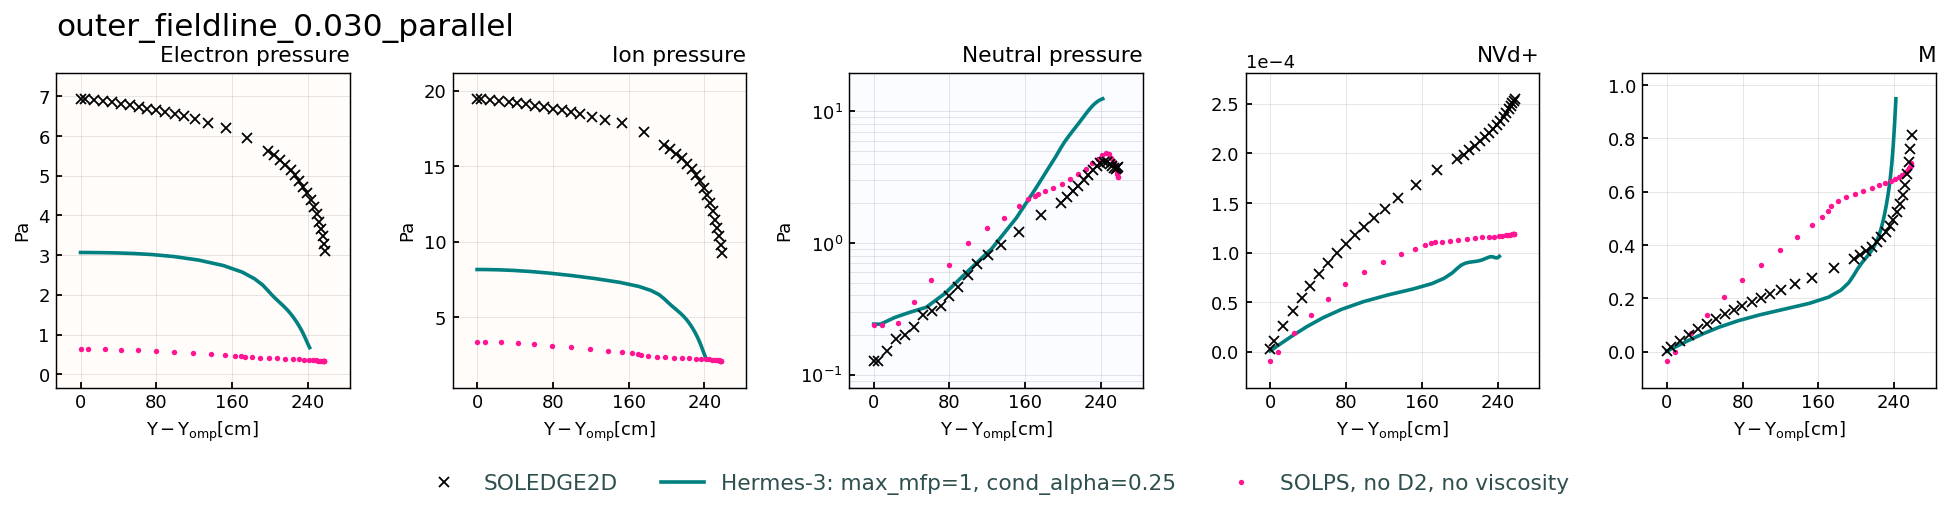

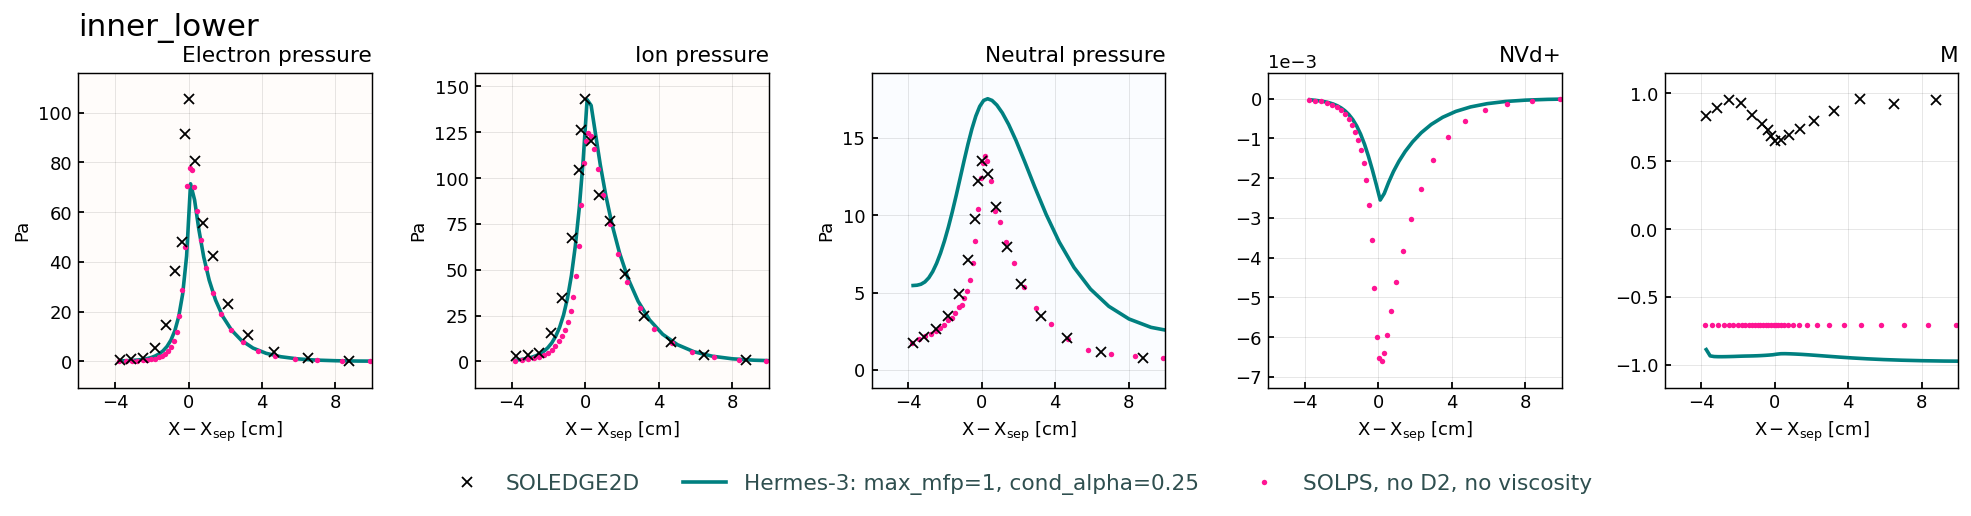

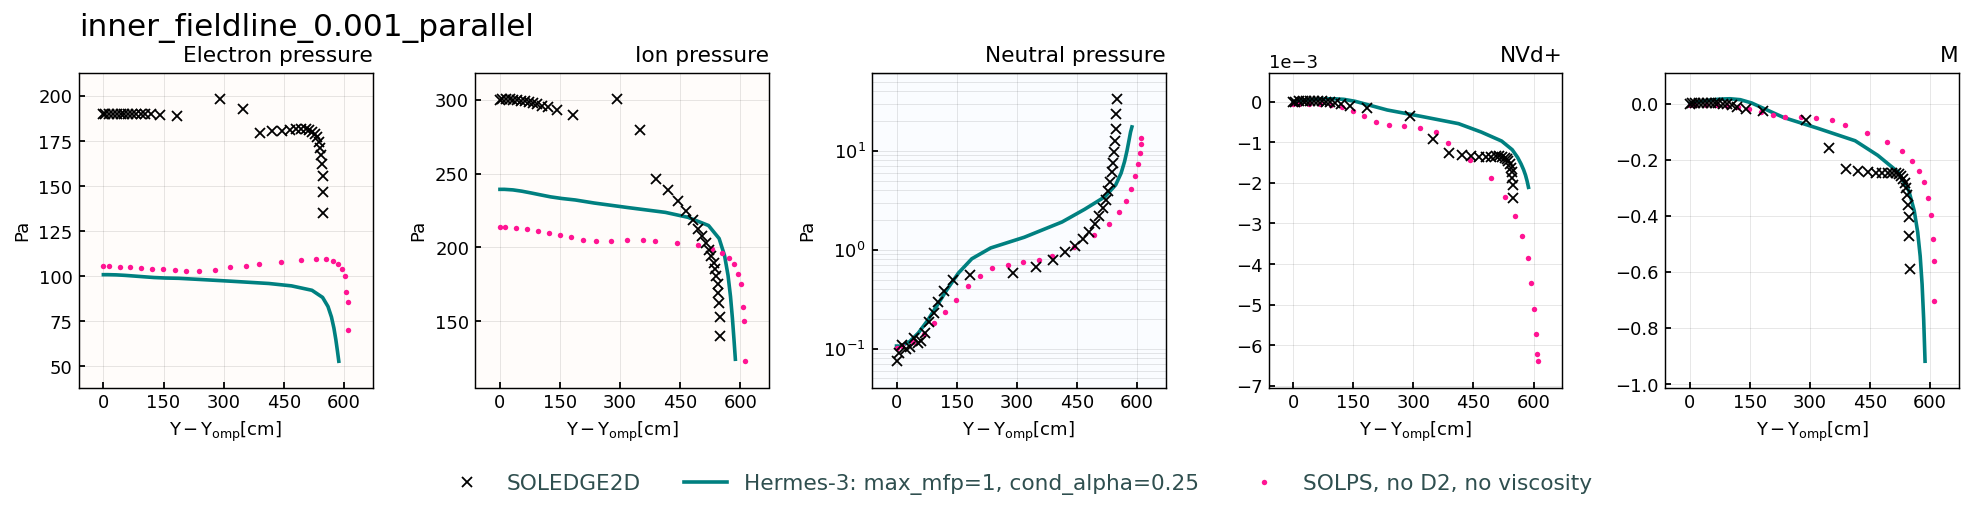

In [24]:
lineplot_compare(
    cases = { 

    "SOLEDGE2D" : dict(data=sl["tightwall_2e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['2e19'], color = "teal"),
    "SOLPS, no D2, no viscosity" : dict(data=sp["tightwall_noD2_2e19_novisc_spectra"], color="deeppink"),



    },
    regions = [
        "omp", "imp", "outer_lower", "outer_fieldline_0.001_parallel", 
        "outer_fieldline_0.030_parallel", "inner_lower", "inner_fieldline_0.001_parallel"],  
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    # params = ["Ne", "Te", "Pe", "Na", "Ta", "Pa"],
    params = ["Pe", "Pd+", "Pa", "NVd+", "M"],
    # params = ["Ne", "Te"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)

## 3e19

In [28]:
for s in [cs, sp, sl]:
    print(s.keys())

dict_keys(['1e19', '2e19', '3e19'])
dict_keys(['tightwall_noD2_1e19_novisc_spectra', 'tightwall_noD2_2e19_novisc_spectra', 'tightwall_noD2_3e19_novisc_spectra', 'tightwall_noD2_3e19_fixpuff_spectra'])
dict_keys(['tightwall_1e19', 'tightwall_2e19', 'widewall_2e19_5m', 'tightwall_3e19', 'widewall_1e19', 'widewall_2e19', 'widewall_3e19'])


None not available in SOLEDGE2D, omp
None not available in SOLEDGE2D, imp
None not available in SOLEDGE2D, outer_lower
None not available in SOLEDGE2D, inner_lower


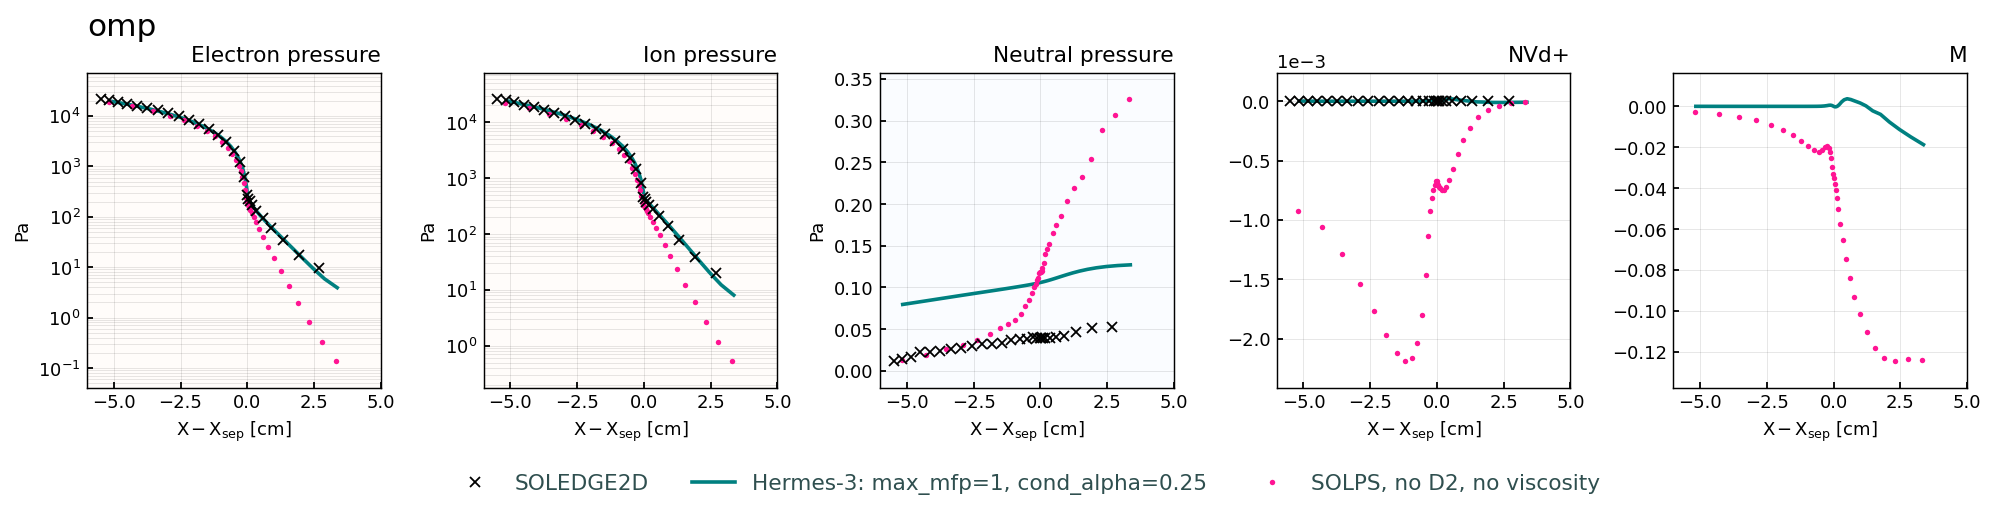

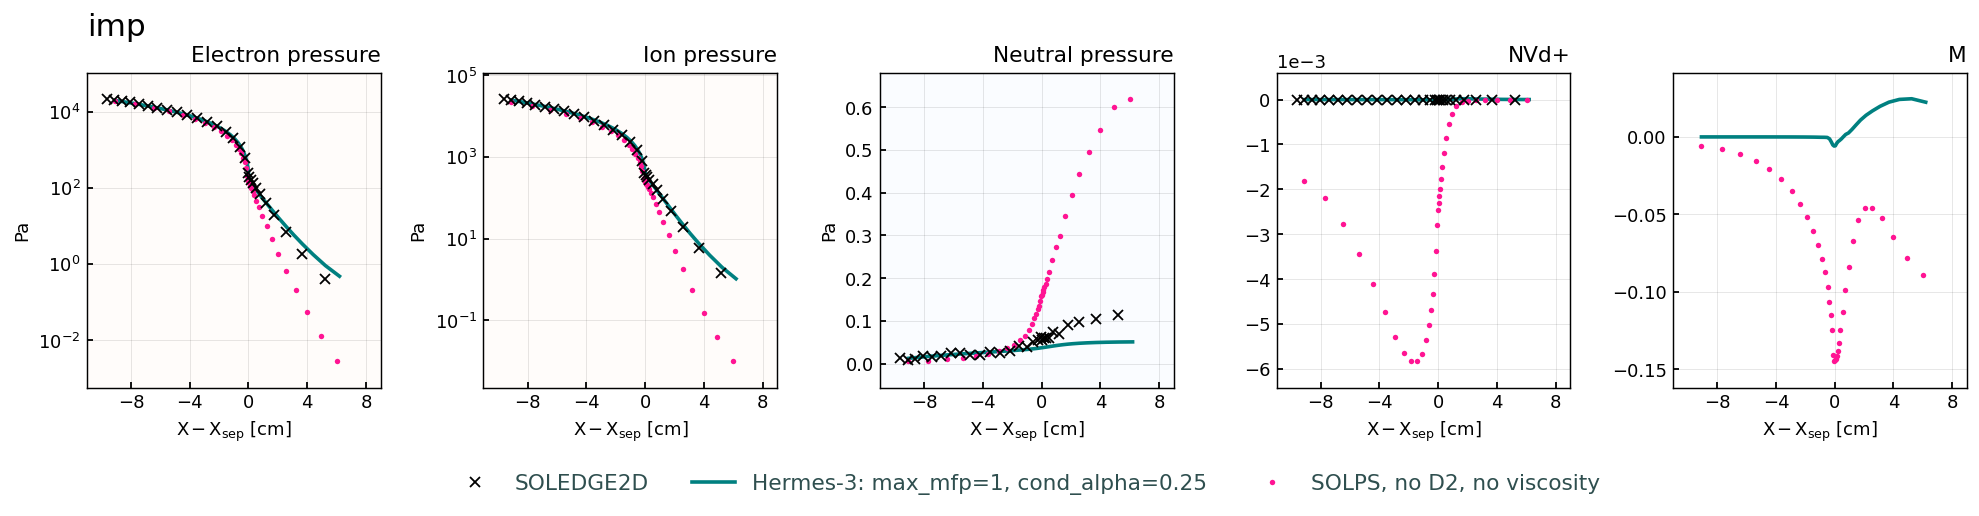

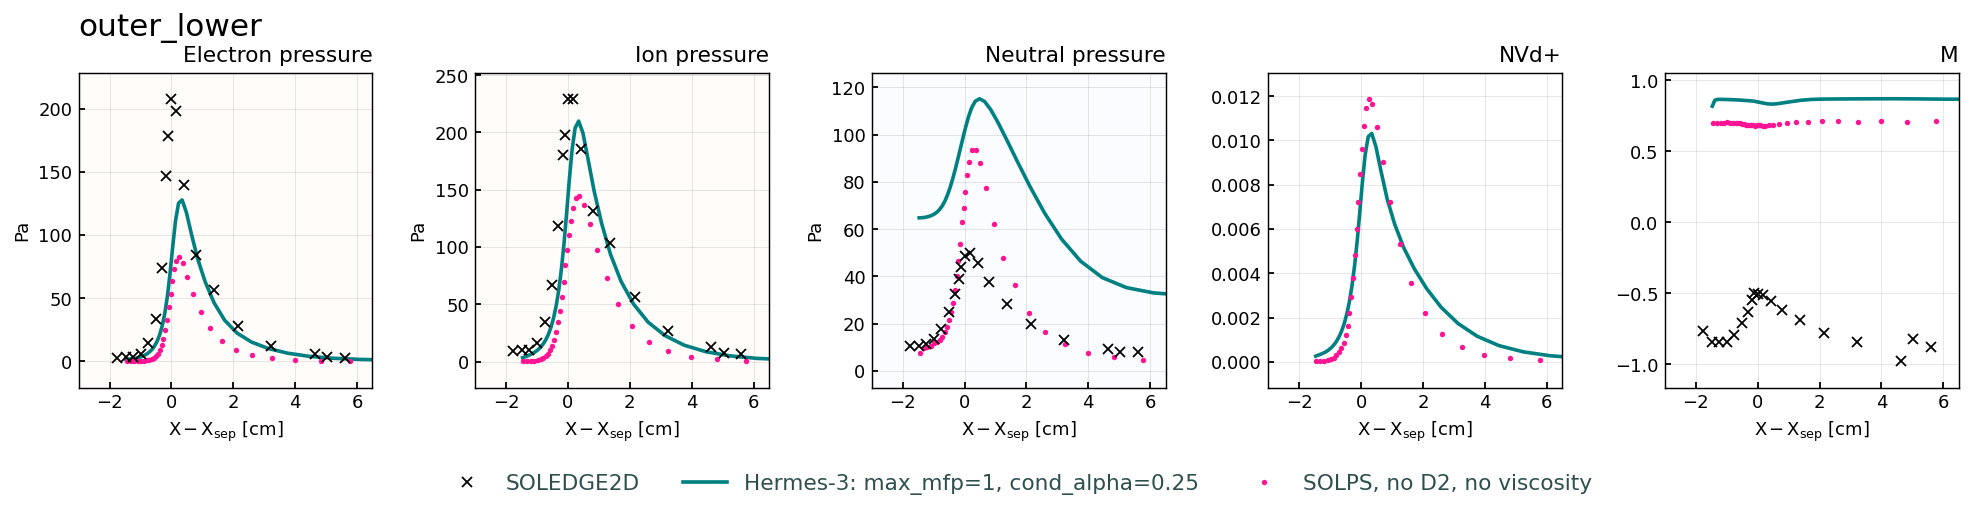

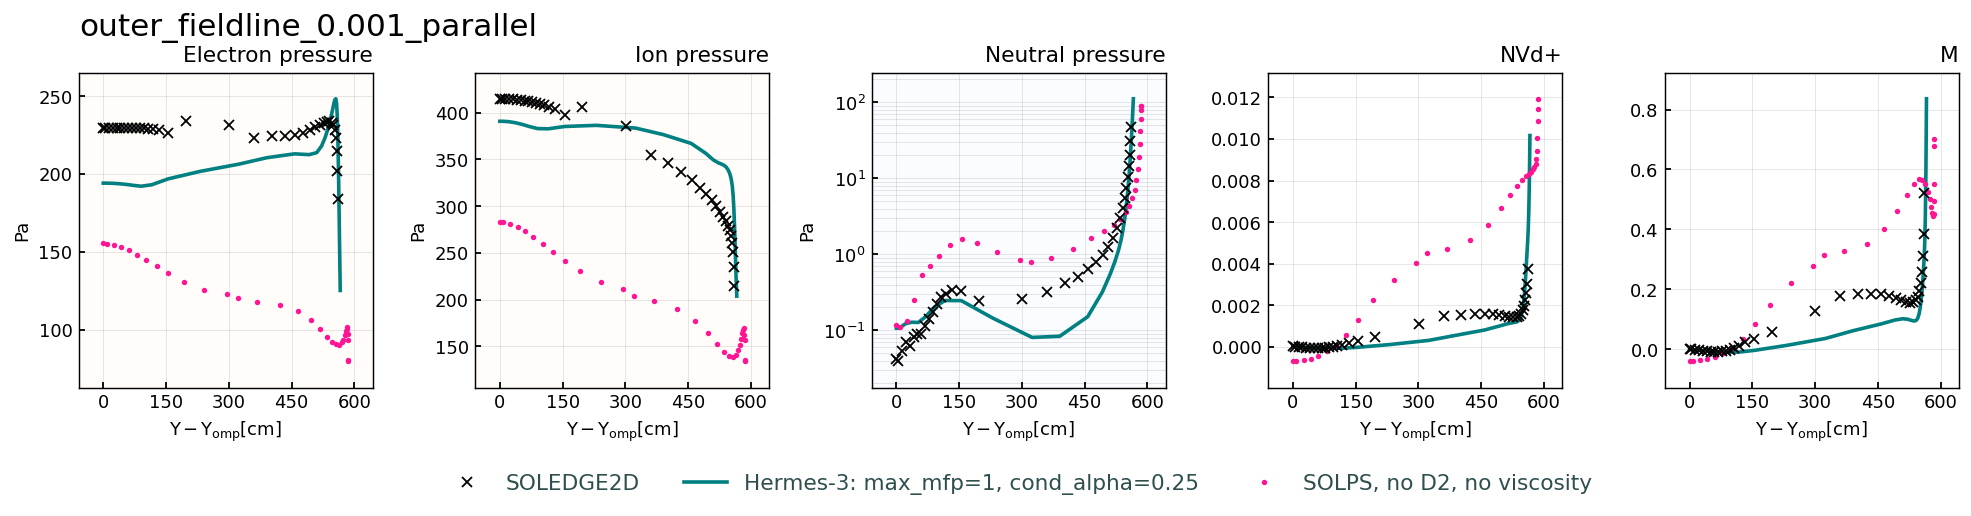

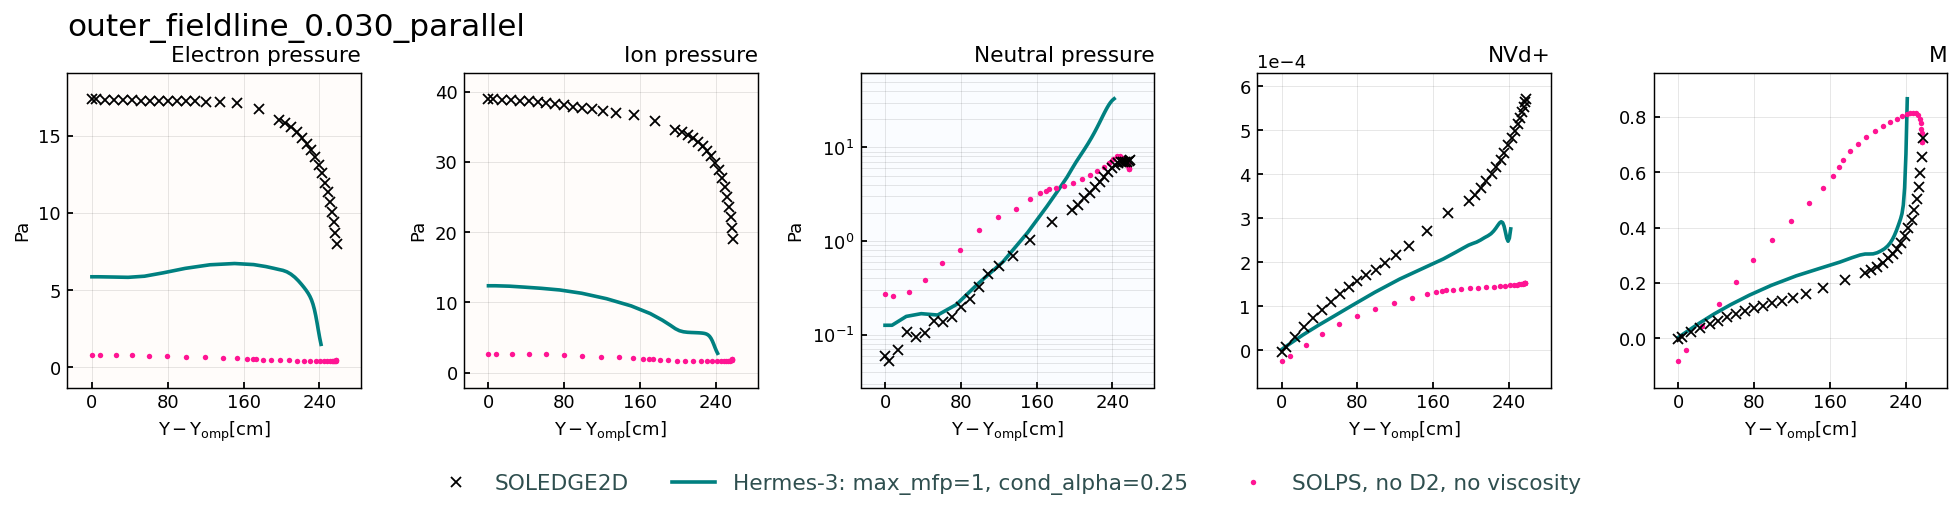

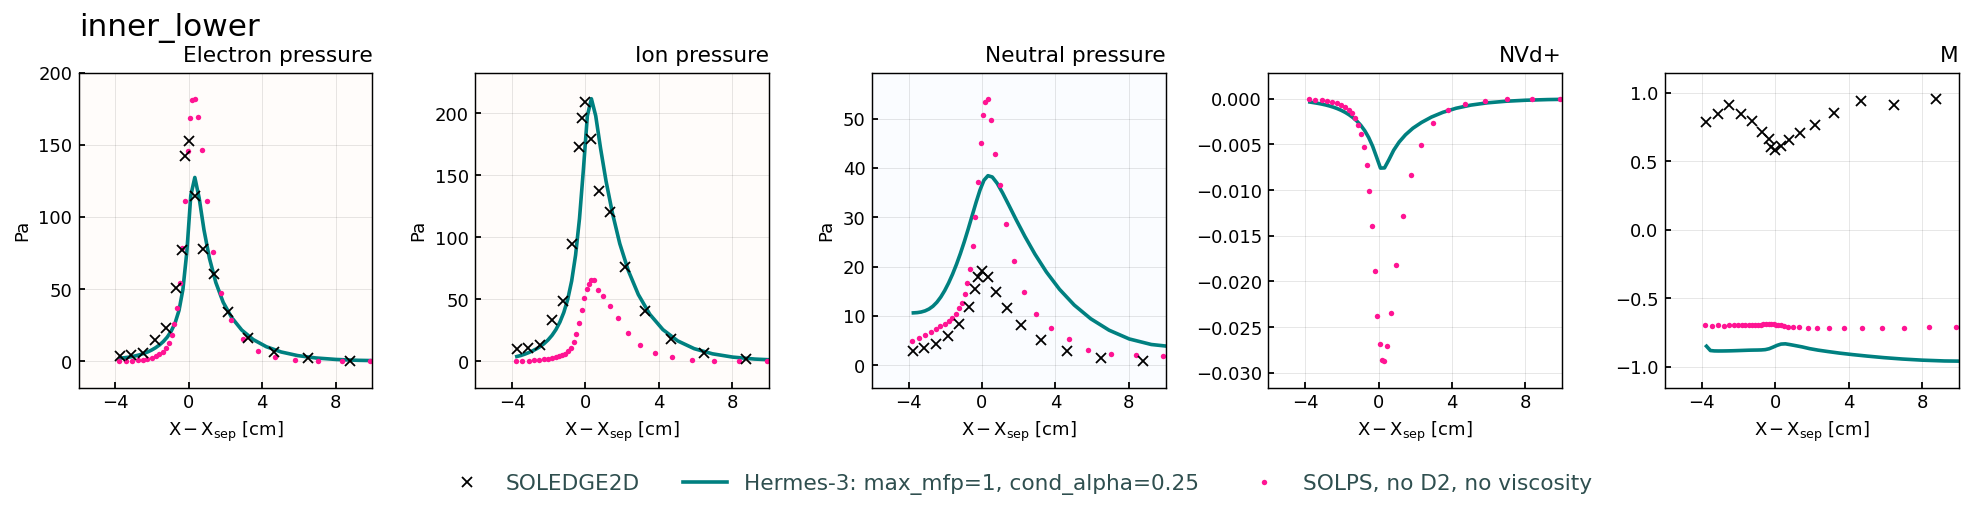

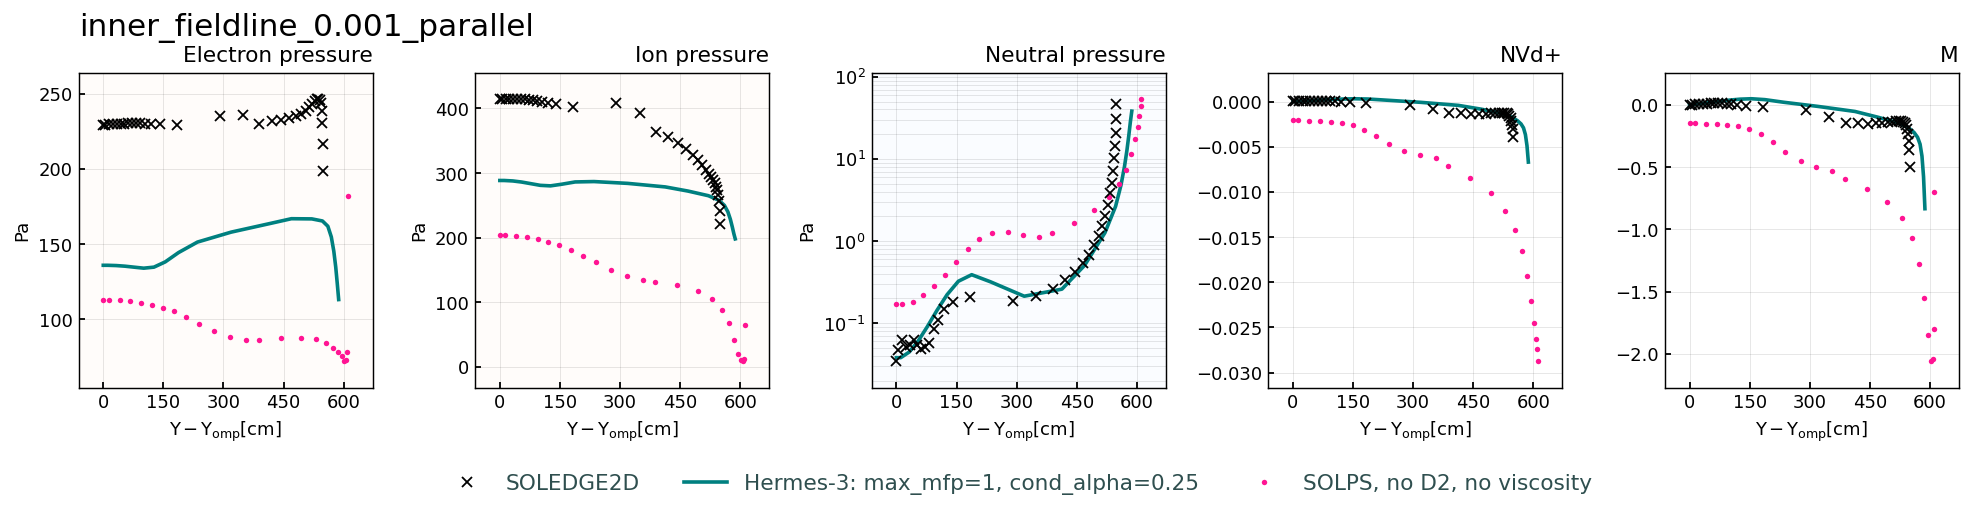

In [25]:
lineplot_compare(
    cases = { 
    # "SOLPS" : dict(data=sp["tightwall_2e19"], color="black"),
    # "SOLPS" : dict(data=sp["tightwall_3e19"], color="black"),
    # "SOLPS, no D2" : dict(data=sp["tightwall_noD2_3e19"], color="red"),
    "SOLEDGE2D" : dict(data=sl["tightwall_3e19"], color="black"),
    r"Hermes-3: max_mfp=1, cond_alpha=0.25" : dict(data=hr['3e19'], color = "teal"),

    # "SOLPS, no D2" : dict(data=sp["tightwall_noD2_3e19_spectrum"], color="black"),
    "SOLPS, no D2, no viscosity" : dict(data=sp["tightwall_noD2_3e19_novisc_spectra"], color="deeppink"),
    # "SOLPS, no D2, no viscosity, fix puff" : dict(data=sp["tightwall_noD2_3e19_fixpuff_spectra"], color="blue"),

    },
    regions = [
        "omp", "imp", "outer_lower", "outer_fieldline_0.001_parallel", 
        "outer_fieldline_0.030_parallel", "inner_lower", "inner_fieldline_0.001_parallel"],  
    # regions = ["outer_fieldline_parallel"],  
    # params = ["Ne", "Te", "Td+", "Na",  "Ta"],
    # params = ["Ne", "Te", "Pe", "Na", "Ta", "Pa"],
    params = ["Pe", "Pd+", "Pa", "NVd+", "M"],
    # params = ["Ne", "Sd+_iz"],
    # params = ["Ne", "Te", "Td+", "Na", "Ta"],
    mode = "log",
    dpi = 100,
    ylims = (5e17, 2e20),
    lw = 2,
    legend_nrows =1,
    combine_molecules = False
)

# Debug wall fluxes

In [95]:

s = sp["tightwall_noD2_1e19_zerophi"].regions["outer_lower"]
sl = sl["tightwall_1e19"].regions["outer_lower"]
h = hr["1e19"].regions["outer_lower"]

Mi = constants("mass_p") * 2


In [96]:
sl.columns

Index(['Ne', 'Te', 'Jsat_e', 'Me', 'Nd+', 'Td+', 'Jsat_d+', 'Md+', ' Ioniz_D',
       'M', 'NVd+', 'Vd+', 'Na', 'Nm', 'Ta', 'Tm', 'Sn', 'Ti', 'walldL', 'L',
       'R', 'Z', 'iWallKnots', 'dist', 'Pe', 'Pd+', 'Pa', 'Pm'],
      dtype='object')

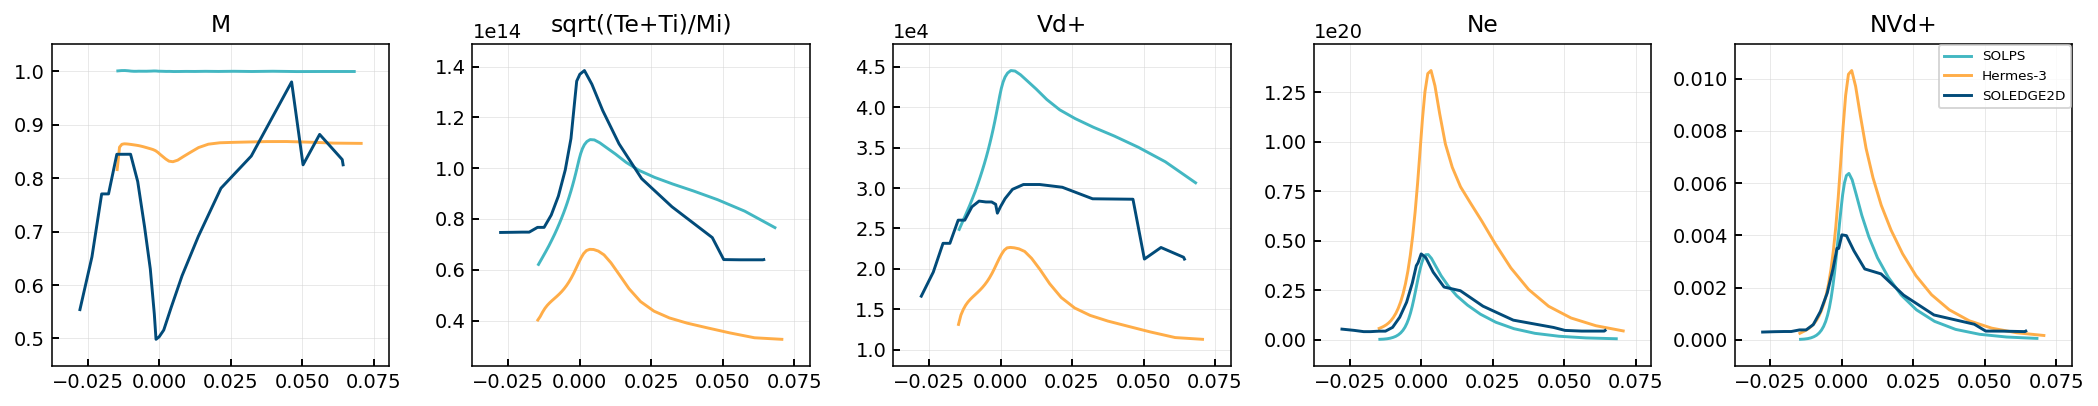

In [29]:
s = sp["tightwall_noD2_3e19_zerophi"].regions["outer_lower"]
l = sl["tightwall_3e19"].regions["outer_lower"].query("-0.03 <= index < 0.07")
h = hr["3e19"].regions["outer_lower"]

Mi = constants("mass_p") * 2

lG = l["Jsat_d+"] / constants("q_e") * constants("mass_p") * 1000000

hr_rec = h["Ne"] * h["Vd+"] * Mi

fig, axes = plt.subplots(1,5, figsize=(15,3))

# for param in ["NVd+"]:

ax = axes[0]
ax.set_title("M")
ax.plot(s.index, s["M"], label = "SOLPS")
ax.plot(h.index, h["M"], label = "Hermes-3")
ax.plot(l.index, l["M"]*-1, label = "SOLEDGE2D")
    
ax = axes[1]
ax.set_title("sqrt((Te+Ti)/Mi)")
ax.plot(s.index, np.sqrt((s["Te"]+s["Td+"])/Mi), label = "SOLPS")
ax.plot(h.index, np.sqrt((h["Te"]+h["Td+"])/Mi), label = "Hermes-3")
ax.plot(l.index, np.sqrt((l["Te"]+l["Td+"])/Mi), label = "SOLEDGE2D")
    
ax = axes[2]
ax.set_title("Vd+")
ax.plot(s.index, s["Vd+"], label = "SOLPS")
ax.plot(h.index, h["Vd+"], label = "Hermes-3")
ax.plot(l.index, l["Vd+"], label = "SOLEDGE2D")

ax = axes[3]
ax.set_title("Ne")
ax.plot(s.index, s["Ne"], label = "SOLPS")
ax.plot(h.index, h["Ne"], label = "Hermes-3")
ax.plot(l.index, l["Ne"], label = "SOLEDGE2D")

ax = axes[4]
ax.set_title("NVd+")
ax.plot(s.index, s["NVd+"], label = "SOLPS")
ax.plot(h.index, h["NVd+"], label = "Hermes-3")
ax.plot(l.index, l["NVd+"], label = "SOLEDGE2D")


fig.tight_layout()
ax.legend(fontsize = "x-small")
# ax.set_yscale("log")

    # ax.set_xlim(-0.02, 0.05)

Text(0.5, 1.0, 'Vd+')

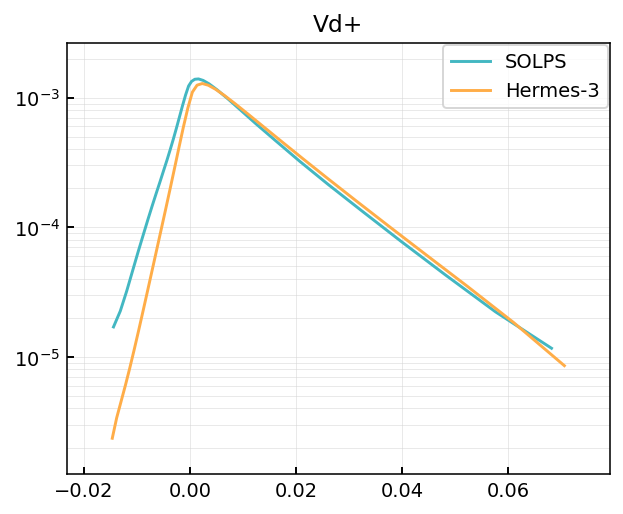

In [ ]:
fig, ax = plt.subplots()

s_rec = s["Ne"] * s["Vd+"] * Mi
h_rec = h["Ne"] * h["Vd+"] * Mi

ax.plot(s.index, s_rec, label = "SOLPS")
ax.plot(h.index, h_rec, label = "Hermes-3")
ax.legend()
ax.set_yscale("log")
ax.set_title(param)